In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, re, sys

# sklearn stuff
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# keras stuff
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

# scipy stuff
from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
def delete_relevant(folder):
    if folder[-1] != '/':
        folder += '/'
    files = os.listdir(folder)
    for f in files:
        if re.match(r'u[0-9]+_w[0-9]+_(accelerometer|gyroscope)\.log', f) == None:
            print('deleting %s' % f)
            os.remove(folder + f)

In [3]:
base = './Data/'
for d in os.listdir(base):
    if os.path.isdir(base + d):
        delete_relevant(base + d)

In [4]:
u_dict = {}
files = [x for x in os.listdir(base) if os.path.isdir(base+x)]
for f in files:
    uid, trial = re.findall(r'u([0-9]+)_w([0-9]+)', f)[0]
    uid, trial = int(uid), int(trial)
    if uid not in u_dict:
        u_dict[uid] = [trial]
    else:
        u_dict[uid].append(trial)

In [5]:
def gen_fname(uid, trial):
    f = lambda x: ('%3d' % x).replace(' ', '0')
    return 'u%s_w%s' % (f(uid), f(trial))

In [173]:
def get_data(uid, trial):
    fname = gen_fname(uid, trial)
    d1 = pd.read_csv('./Data/%s/%s_accelerometer.log' % (fname, fname), delimiter='\t')
    d2 = pd.read_csv('./Data/%s/%s_gyroscope.log' % (fname, fname), delimiter='\t')
    df = d1.join(d2)
    return df[[x for x in df.columns.values if 'data' in x]]

# Steps to extract cycles

1. discard the first 500 readings (assume sampling rate of 50Hz)
2. discard readings until first local minimum
3. assume template size of 150 readings

In [207]:
def corr(x1, x2):
    """
    input: x1, x2 (vectors of equal length)
    output: pearson correlation coefficient
    """
    n = len(x1)
    return (x1.dot(x2) - n * x1.mean() * x2.mean())/(n * x1.std() * x2.std())

In [206]:
def find_cycles(data, step=150, slack=20, threshold=0.45, viz=False):
    """
    input: data [accelerometer magnitude time series]
    output: starts [start of each step]
    
    find starts of each cycle
    default vales for:
        step = 150
        slack = 20
        threshold = 0.45
    """
    counter = 0
    
    N = len(data)
    start_idx = np.argmin(data[:step])
    end_idx = start_idx+step-slack + np.argmin(data[start_idx+step-slack:start_idx+step+slack])

    R1 = data[np.arange(start_idx, end_idx)]
    L = end_idx - start_idx
    
    c = []
    for i in range(N-L):
        Di = data[i:i+L]
        ci = corr(R1, Di)
        c.append(ci)
    
    if viz:
        plt.figure(figsize=(15,4))
        plt.title('Correlation')
        plt.plot(c)
    
    starts = []
    for i in range(1, N-L-1):
        if c[i] > c[i-1] and c[i] > c[i+1] and c[i] > threshold:
            starts.append(i)
    
    return starts

In [310]:
def filter_datapoints(data, threshold=0.25):
    """
    input:
        data (list of lists containing individual cycle values in each list)
        threshold [optional] (threshold value for length of lists to include
        eg. 0.25 mean lists of 0.75 < len < 1.25)
    output: list of lists
    
    filters out very long lists and very short lists
    """
    # immediately remove samples less than 80 or greater than 300
    lengths = [len(x) for x in data if len(x) >= 80 and len(x) <= 300]
    mean_len = np.mean(lengths)
    return [x for x in data if len(x) <= (1 + threshold) * mean_len and len(x) > (1 - threshold) * mean_len]

In [311]:
def extract_feats(data, starts, threshold=0.25, filter_short=True):
    """
    input:
        data (time series)
        starts (start of each cycle)
        filter_short [optional] (filters out short cycles)
    output: out (list of lists containing individual cycle values in each list)
    """
    ns = len(starts)
    out = []
    for i in range(ns-1):
        out.append(data[starts[i]:starts[i+1]])
    if filter_short:
        return filter_datapoints(out, threshold)
    return out

In [312]:
def plot_steps(data, starts, main_title='Accelerometer Magnitude', main_ylabel='$m/s^2$'):
    """
    plots overall time series with starts overlayed
    plots individual walking cycles
    """
    
    plt.figure(figsize=(15,4))
    plt.plot(data)
    plt.title(main_title)
    plt.xlabel('samples')
    plt.ylabel(main_ylabel)
    mx = data.max()
    mn = data.min()
    vy = np.linspace(mn, mx, 2)

    for s in starts:
        vx = [s for _ in vy]
        plt.plot(vx, vy, c='r', linewidth=2)
    plt.show()
    
    plt.figure(figsize=(15,4))
    plt.title('Individual Walking Cycles')
    plt.xlabel('samples')
    plt.ylabel(main_ylabel)
    for s in extract_feats(data, starts):
        plt.plot(s)

In [313]:
def interpolate_features(feats, num=300):
    """
    input:
        feats (list of lists containing individual cycle values in each list)
        num [optional] (number of points to interpolate to)
    output: feats_interp (interpolated list of lists of same length)
    """
    feats_interp = []
    for point in feats:
        n = len(point)
        f = interp1d(np.arange(n), point, kind='cubic')
        point_interp = np.linspace(0, n-1, num=num, endpoint=True)
        feats_interp.append(f(point_interp))
    feats_interp = np.array(feats_interp)
    return feats_interp

In [314]:
def rot_trans(raw_data):
    """
    input: raw_data
    output: rotation invariant data via linear PCA
    """
    n, d = raw_data.shape
    pca = PCA(n_components=d)
    return pca.fit_transform(raw_data)

In [315]:
def preprocess_data(df, begin_idx=1000, threshold=0.25):
    """
    input: df (dataframe of accelerometer readings. 1 column for each axis. Each row must be at one timestamp)
    output: out (dataframe of interpolated, distinct step data values)
    """
    # keep accelerometer columns
    accelerometer_cols = [x for x in df.columns if 'acc' in x]
    # rotation invariance transformation
    data = rot_trans(df[accelerometer_cols].values)
    # toss first few values to noise/errors
    data = data[begin_idx:, :]
    
    # calculate accelerometer magnitude
    acc_mag = (data ** 2).sum(axis=1) ** 0.5
    
    # calculate start of each cycle
    starts = find_cycles(acc_mag)
    
    # [n x k*c] matrix where
    # n = number of distinct cycles
    # k = number of axes in accelerometer
    # c = number of interpolated columns
    out = []
    columns = []
    for idx, row in enumerate(data.T):
        feats = extract_feats(row, starts, threshold=threshold, filter_short=True)
        feats_interp = interpolate_features(feats)
        n, d = feats_interp.shape
        out.append(feats_interp)
        ctr = 0
        for i in range(d):
            columns.append('axis_%d_feat_%d' % (idx, i))
    out = np.concatenate(out, axis=1)
    return pd.DataFrame(out, columns=columns)

# Trials

In [217]:
a = get_data(10, 2)
accelerometer_cols = [x for x in a.columns if 'acc' in x]
gyroscope_cols = [x for x in a.columns if 'gyr' in x]

In [218]:
data = rot_trans(a[accelerometer_cols].values)
acc_mag = (data ** 2).sum(axis=1) ** 0.5

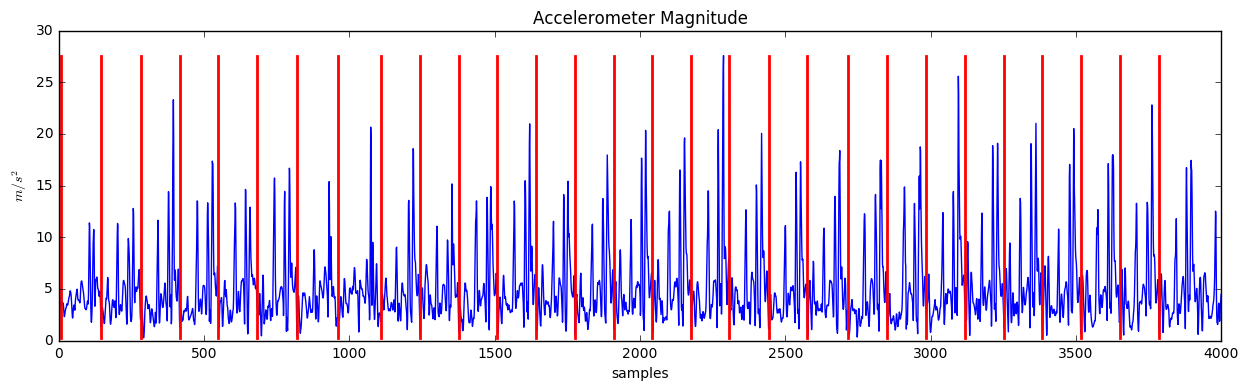

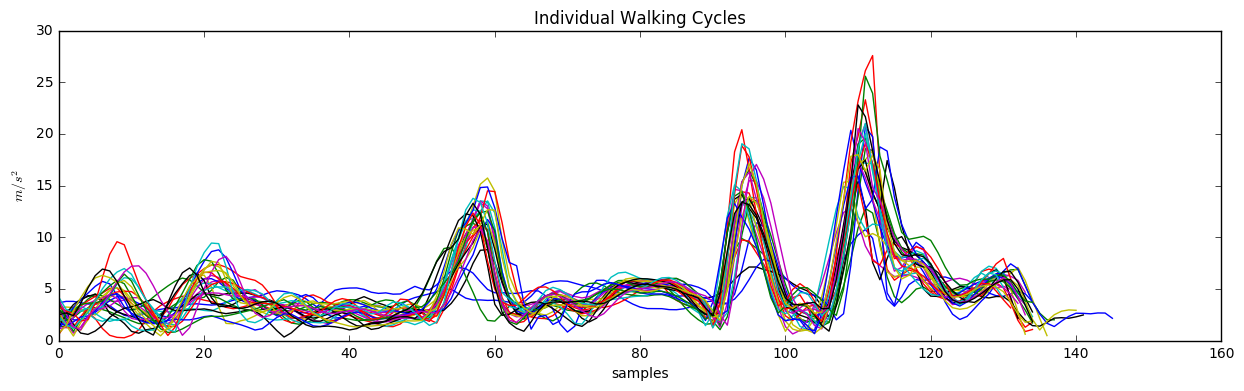

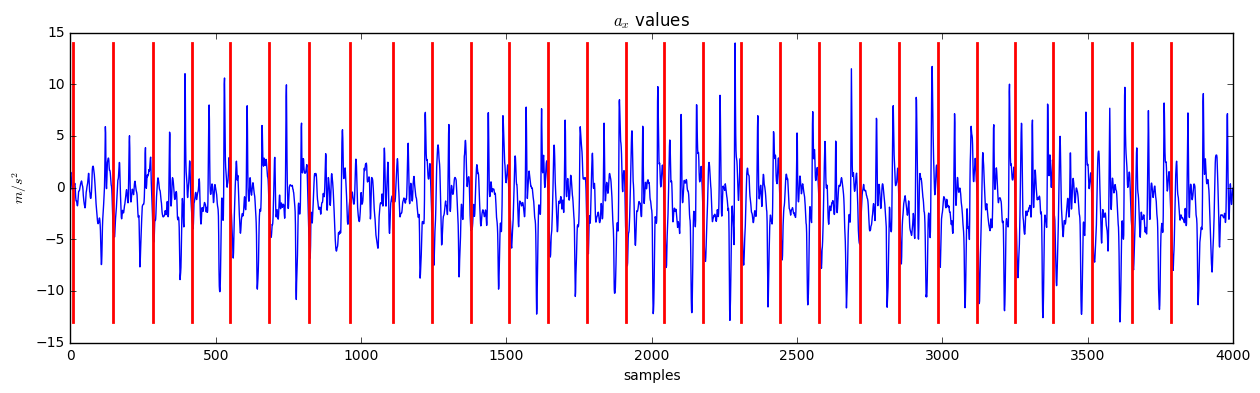

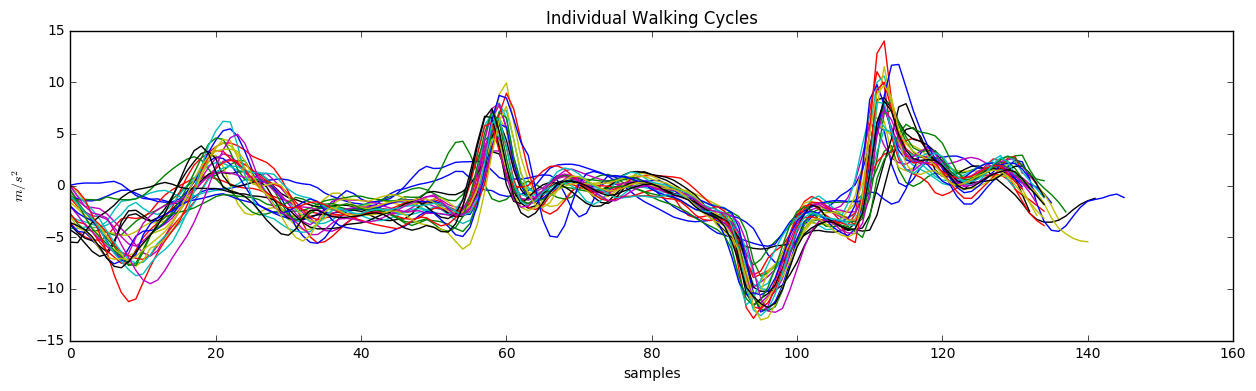

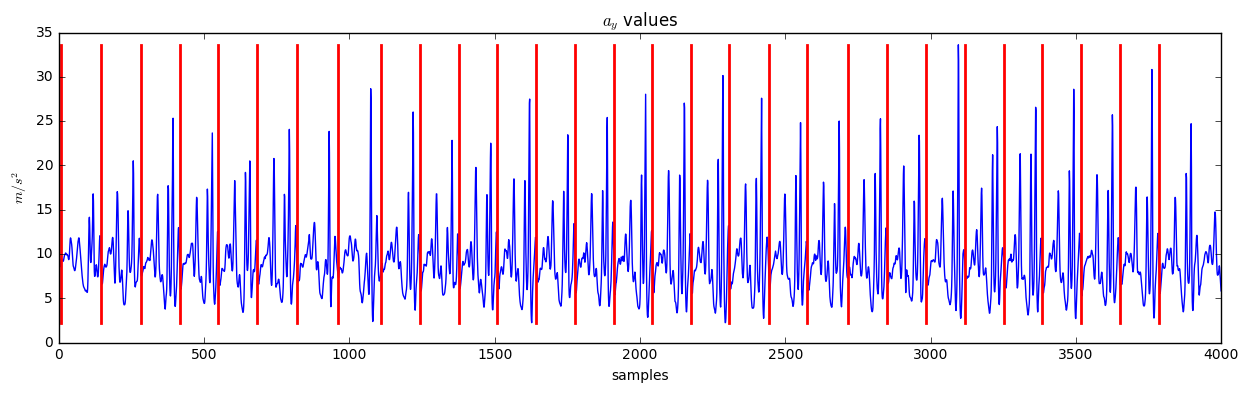

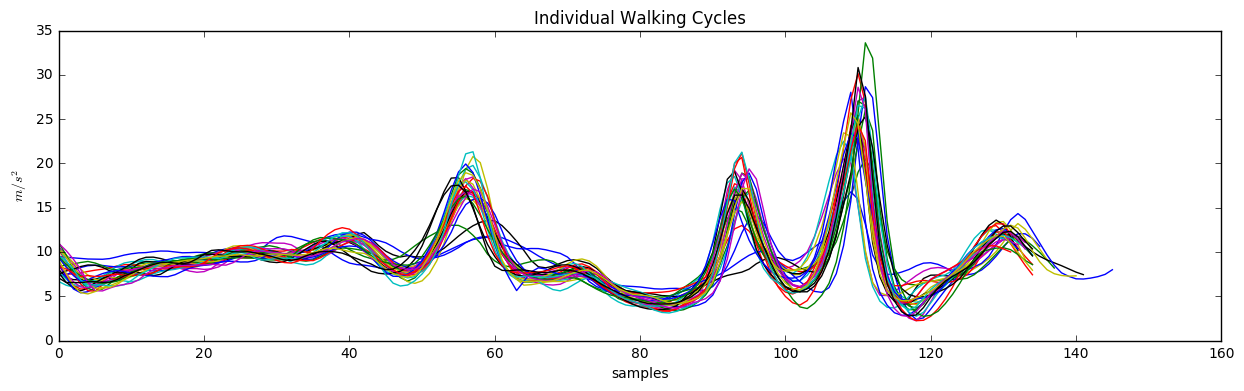

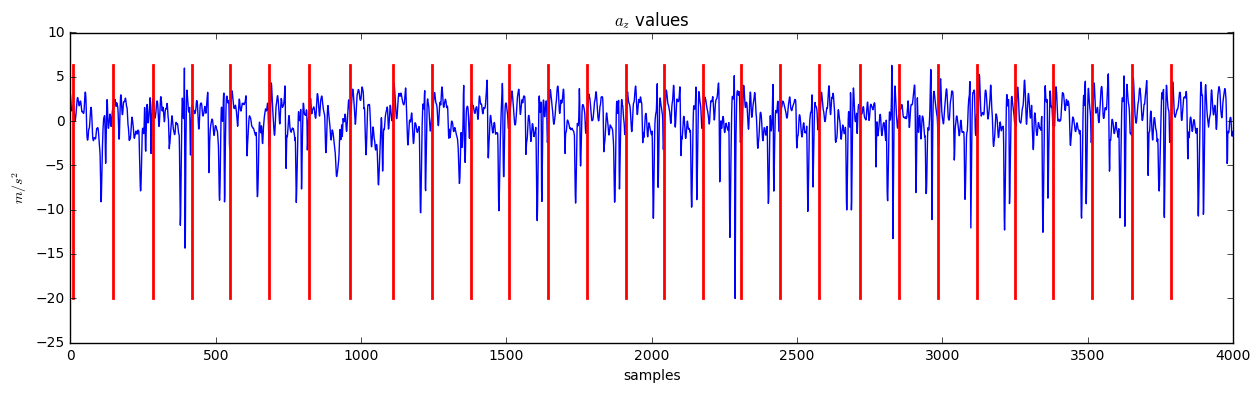

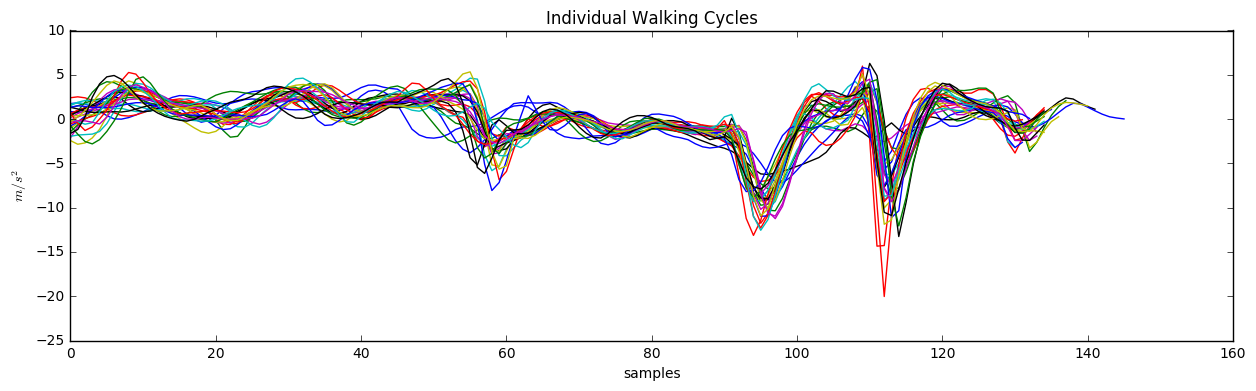

In [221]:
samples2 = acc_mag[1000:5000]
starts = find_cycles(samples2)
plot_steps(samples2, starts)

x,y,z=a[accelerometer_cols].values[1000:5000, :].T
plot_steps(x, starts, main_title='$a_x$ values')
plot_steps(y, starts, main_title='$a_y$ values')
plot_steps(z, starts, main_title='$a_z$ values')

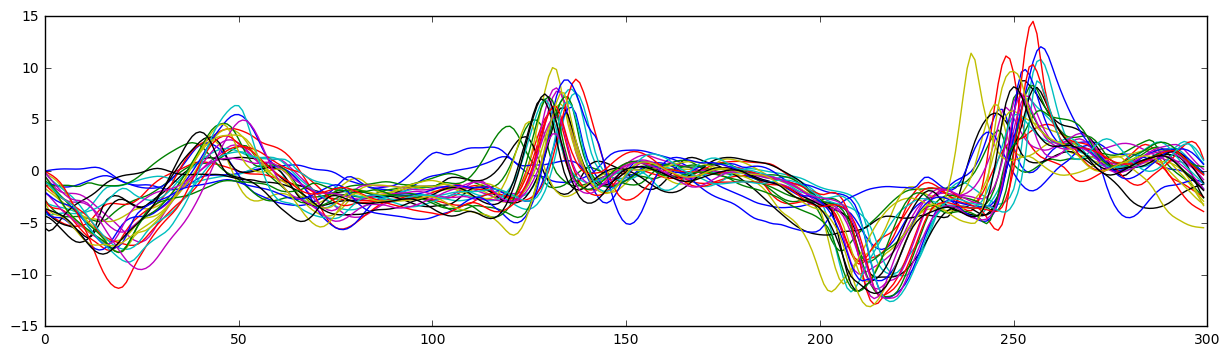

In [227]:
feats = extract_feats(x, starts, filter_short=True)
feats_interp = interpolate_features(feats)
plt.figure(figsize=(15,4))
for row in feats_interp:
    plt.plot(row)

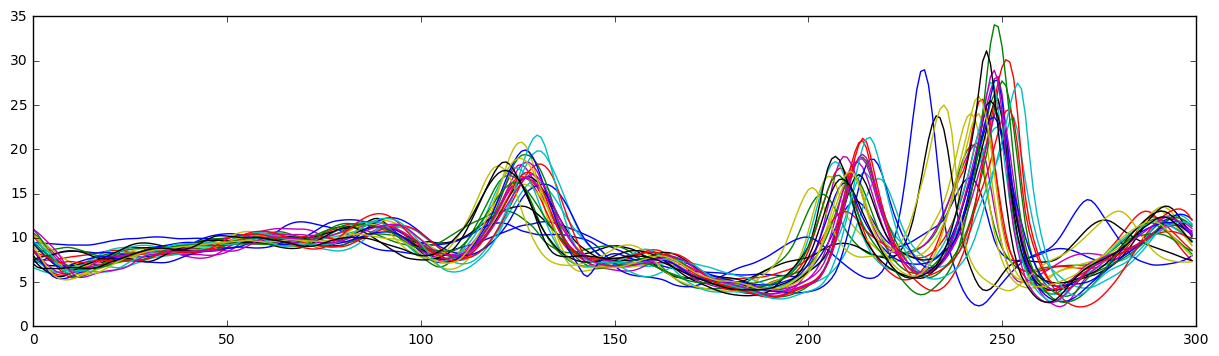

In [228]:
feats = extract_feats(y, starts, filter_short=True)
feats_interp = interpolate_features(feats)
plt.figure(figsize=(15,4))
for row in feats_interp:
    plt.plot(row)

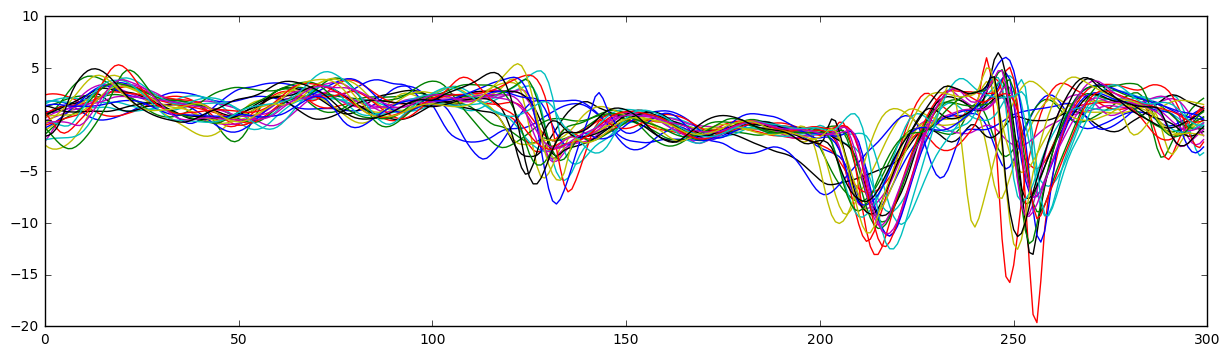

In [229]:
feats = extract_feats(z, starts, filter_short=True)
feats_interp = interpolate_features(feats)
plt.figure(figsize=(15,4))
for row in feats_interp:
    plt.plot(row)

# Preprocess and save data